### Exercise on SL scheme
- Write a program to integrate the linear advection equation in
\begin{equation}
    \frac{\partial \phi}{\partial t} + u \frac{\partial \phi}{\partial x} = 0
\end{equation}
using the SL scheme with linear interpolation in the domain $0 \leq x \leq 1000\,m$ with advection velocity $u = 0.75\,m\,s^{-1}$ . Let $\Delta x = 0.5\,m$ and assume periodic boundary conditions. Assume the initial shape to be:
$$ \phi(x, 0)=  \left\{
\begin{array}{ll}
      0.0 \quad \mathrm{for} \quad x<400 \\
      0.1(x-400.0 \quad \mathrm{for} \quad 400 \leq x \leq 500 \\
      20.0 - 0.1(x-400.0) \quad \mathrm{for} \quad 500 \leq x \leq 600 \\
      0.0 \quad \mathrm{for} \quad x > 600 \\
\end{array} 
\right. $$ 

- Integrate forward and show solutions from $t=0\,s$ to $t = 2000\,s$ every $250\,s$ and explain the characteristics of the solution.
- Repeat the exercise using cubic interpolation

**Question:** Do we need to worry about the CFL condition? Explain why or why not.

**Answer:** Based on the produced plots below, we can see that the regardless of the value of Courant number it doesn't affect somehow its stability compare to the Finite Difference Scheme. However, the choice                                                                    

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [41]:
class SLscheme1D:
    """
    SemiLagrangian scheme for periodic 1D problems.
    """
    def __init__(self, x0, x1, t0, t1, u, dx, dt, tp):
        """
        Initizalizes the SemiLagrangian object given initial configuration
        x : x positions (must be equidistant)
        y : variable at all x positions at time t
        u : speed of advection
        dt: time step
        """
        self.x0 = x0  
        self.x1 = x1 
        self.t0 = t0
        self.t1 = t1
        self.u = u
        self.dx = dx
        self.dt = dt
        self.tp = tp
        self.c = u*(dt/dx)
        self.nx = round((x1 - x0) / dx) + 1
        self.x = np.linspace(x0,x1,self.nx)
        self.y = np.array([self.phi0(xi) for xi in self.x])
        
        #Check dimensions
        assert self.x.shape[0] == self.y.shape[0], "x and y have different length"
        #Get the x stepsize
        self.dx = self.x[1] - self.x[0]
        # check if x is equidistant
        assert self.x[-1] == self.x[0] + self.dx*(self.x.shape[0]-1), "x array not equidistant"
        # Set class variables

    def phi0(self, x):
        if x < 400.0 or x > 600.0:
            return 0.0
        elif x >= 400 and x < 500:
            return 0.1*(x-400.0)
        else:
            return 20.0-0.1*(x-400)

    def linear_interpolation(self):
        y_temp = np.zeros(self.y.shape[0])
        for i in range(self.y.shape[0]):
            #departure point
            x_dep = self.x0 + (self.x[i]-self.u*self.dt)%(self.x1-self.x0)
            if x_dep < self.x0:
                x_dep += self.x1
            # idx left to the departure point
            j = int(np.floor(x_dep/self.dx))
            # linear interpolation
            alpha = (x_dep/self.dx)-j
            # idx right to the departure point
            k = j+1
            if k == self.nx:
                k = 0
            y_temp[i] = (1-alpha)*self.y[k] + alpha*self.y[j]
        # copy array to current time
        self.y = np.copy(y_temp)
        #return current varibale
        return self.y

    def cubic_interpolation(self):
        #loop through time steps
        y_temp = np.zeros(self.y.shape[0])
        for i in range(self.y.shape[0]):
            #x_dep = self.x[i]-self.u*self.dt
            x_dep = self.x0 + (self.x[i]-self.u*self.dt)%(self.x1-self.x0)
            if x_dep < self.x0:
                x_dep = self.x1 + x_dep
            j = int(np.floor(x_dep/self.dx))
            # alpha
            a = (x_dep/self.dx)-j
             # calculate next time step
            f = lambda x: x % self.y.shape[0] if x >= self.y.shape[0] else x
            y_temp[i] = - a * (1-a)*(2-a)/6 * self.y[f(j-1)]
            y_temp[i] += (1-a**2)*(2-a)/2 * self.y[f(j)]
            y_temp[i] += a*(1+a)*(2-a)/2 * self.y[f(j+1)]
            y_temp[i] -= a*(1-a**2)/6 * self.y[f(j+2)]
        self.y = np.copy(y_temp)
        return self.y

    def plot(self, interpolation='linear'):
        t = self.t0
        plt.plot(self.x, self.y, label=f'$\phi$({int(t)} s)', linestyle='-', color='black')
        while t < self.t1:
            if interpolation == 'Linear' or interpolation == 'linear' or interpolation == 'LINEAR':
                self.linear_interpolation()
            elif interpolation == 'Cubic' or interpolation == 'cubic' or interpolation == 'CUBIC':
                self.cubic_interpolation()
            t += self.dt
            if np.mod(t, self.tp) < self.dt:
                plt.plot(self.x, self.y, label=f'$\phi$({int(round(t))} s)')
            
        plt.xlabel('x')
        plt.suptitle(r'Semi-Lagragian Scheme $\quad \frac{\partial \phi}{\partial t} = -u \frac{\partial \phi}{\partial x}$', fontsize=14)
        plt.title(rf'{interpolation} $\Delta t =$ {np.round(self.dt,2)}, $u =$ {np.round(self.u, 2)}')
        plt.legend(loc='upper right', fontsize='small', bbox_to_anchor=(1.25, 1))
        plt.tight_layout()  # Ensures everything fits properly
        plt.savefig(f'Semi-Lagragian_interpolation = {interpolation}_tp={self.tp}_dt={self.dt}.png')
        plt.show()

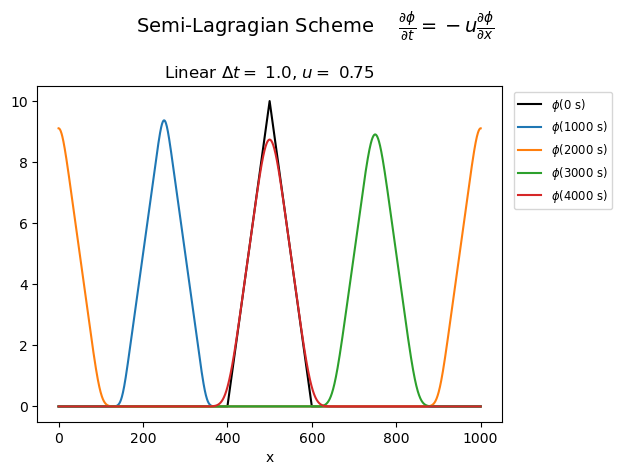

In [42]:
# Parameters
x0 = 0.0
x1 = 1000.0
t0 = 0.0
t1 = 4000.0
u = 0.75
dx = 0.5
dt = 1.0
tp = 1000.0


# Integrate forward and show solutions with linear interpolation
SLscheme1D(x0, x1, t0, t1, u, dx, dt, tp).plot(interpolation='Linear')

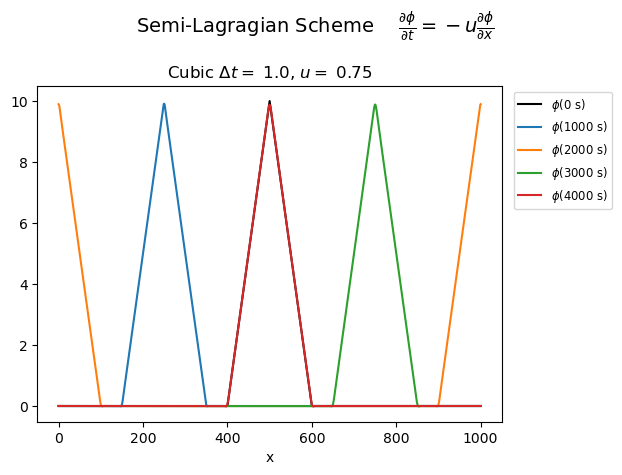

In [8]:
SLscheme1D(x0, x1, t0, t1, u, dx, dt, tp).plot(interpolation='Cubic')

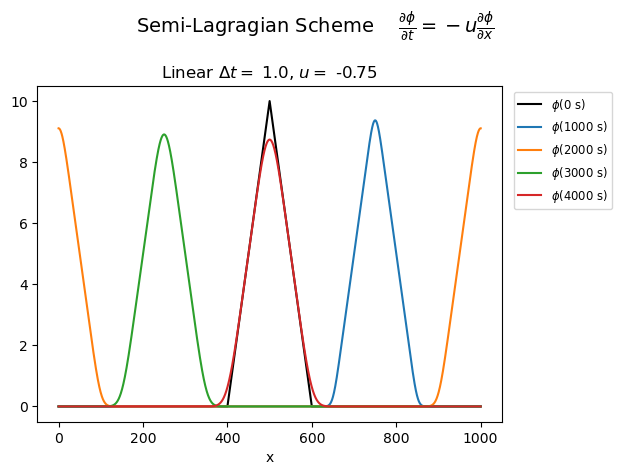

In [9]:
SLscheme1D(x0, x1, t0, t1, -u, dx, dt, tp).plot(interpolation='Linear')

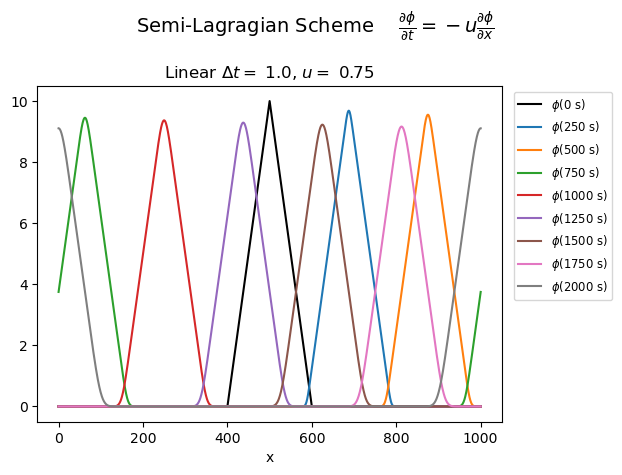

In [43]:
SLscheme1D(x0, x1, t0, 2000, u, dx, dt, 250).plot(interpolation='Linear')

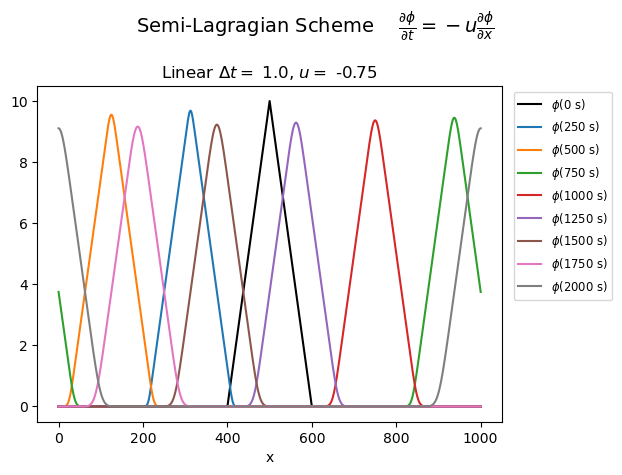

In [44]:
SLscheme1D(x0, x1, t0, 2000, -u, dx, dt, tp=250).plot(interpolation='Linear')

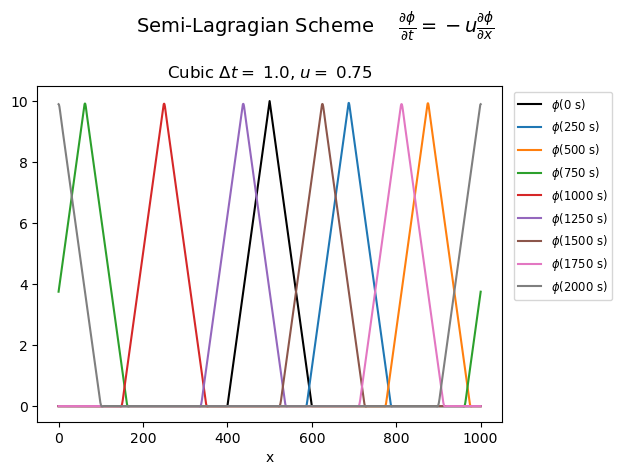

In [40]:
SLscheme1D(x0, x1, t0, 2000, u, dx, dt, tp=250).plot(interpolation='Cubic')

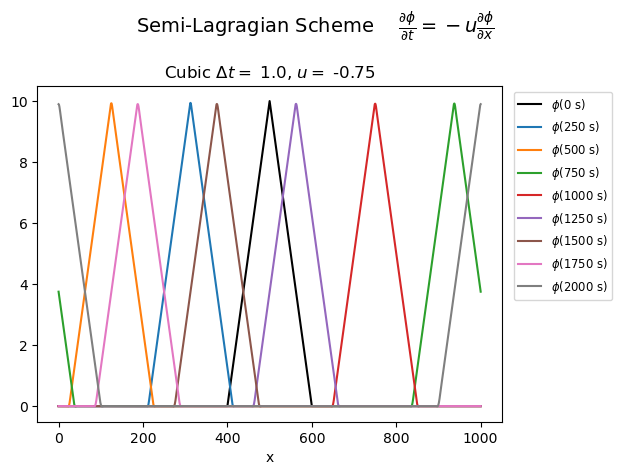

In [13]:
SLscheme1D(x0, x1, t0, 2000, -u, dx, dt, tp=250).plot(interpolation='Cubic')

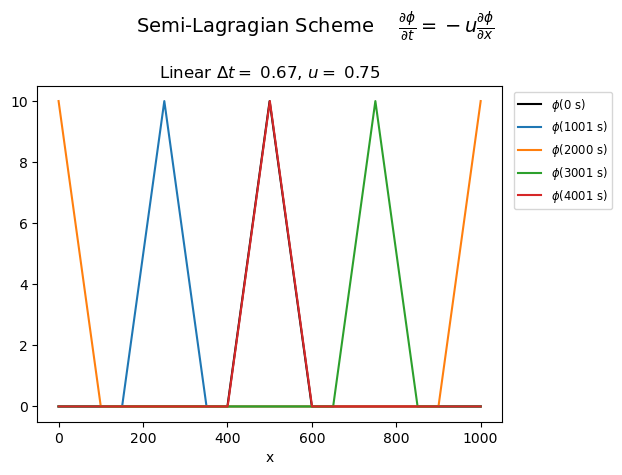

In [14]:
SLscheme1D(x0, x1, t0, t1, u, dx, dx/u, tp).plot(interpolation='Linear')

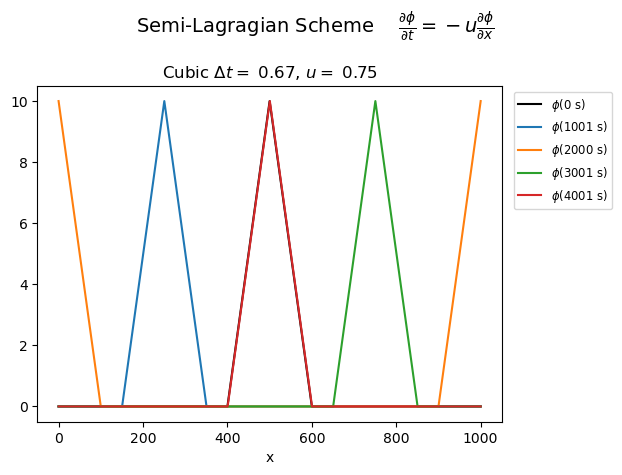

In [15]:
SLscheme1D(x0, x1, t0, t1, u, dx, dx/u, tp).plot(interpolation='Cubic')

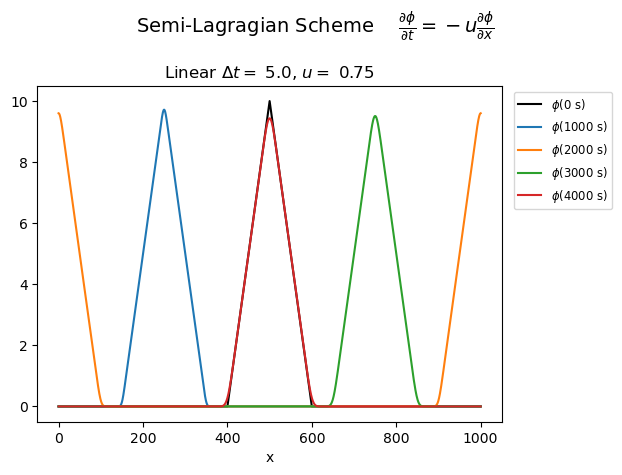

In [16]:
SLscheme1D(x0, x1, t0, t1, u, dx, 5.0, tp).plot(interpolation='Linear')

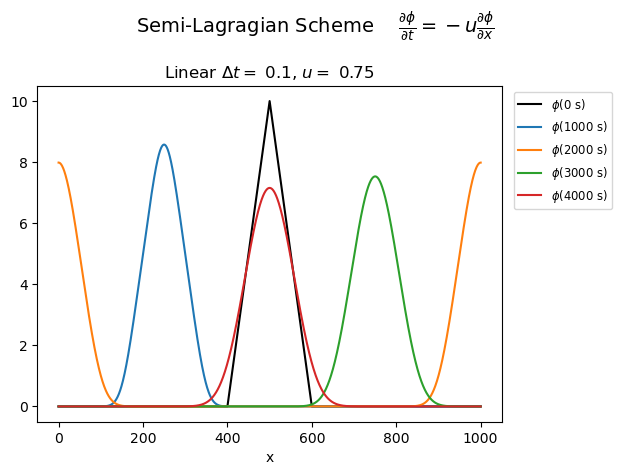

In [17]:
SLscheme1D(x0, x1, t0, t1, u, dx, 0.1, tp).plot(interpolation='Linear')

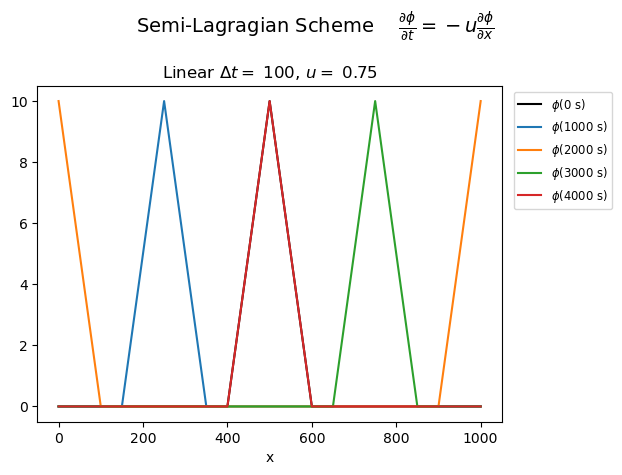

In [18]:
SLscheme1D(x0, x1, t0, t1, u, dx, 100, tp).plot(interpolation='Linear')

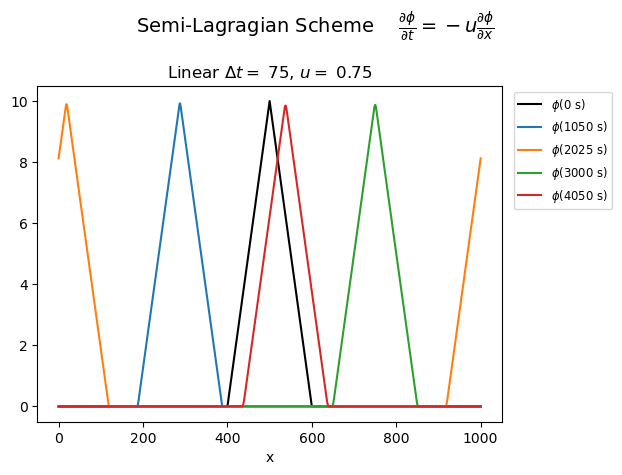

In [19]:
SLscheme1D(x0, x1, t0, t1, u, dx, 75, tp).plot(interpolation='Linear')